# Procedural cave generation
Based on the Youtube video https://www.youtube.com/playlist?list=PLFt_AvWsXl0eZgMK_DT5_biRkWXftAOf9

Programmed by the Ing. Alan Fernando Santacruz Rodríguez

You are welcome to improve the code, invite a coffee or to the video autor, or use to your projects.

# Libraries that are used in this project

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import namedtuple
import seaborn as sns;

# Creation of the map
Variables to control the procedural creation

In [215]:
width=100               ##Anchor in X of the map to be generated
height=100              ##Anchor in y of the map to be generated
borderSize=2            ##A border size that will be added to every axis, to center the created map
randomFillPercent=0.5   # 0-> 1  ##What probability is used to create a passage
SoftLoops=5             # Soft Loops, to suavize the map
random.seed(10)         # What seed is used to create this map, is useful to replicate some one created
wallThresholdSize=50    # Value of minimum tiles to create an island in the map, an island is a group of walls connected
roomThresholdSize=50    # Value of minimum titles to create a room in the map
PassageSize=5

## Step 0: Map plotter
For visualization or begging process, i need to see a way to see what i am doing

In [216]:
def ShowMap(Map):
    plt.imshow(Map.transpose())

## Step 1: Randomize the matrix
Don't are randomized the borders, be careful with that

In [217]:
def RandomMap(width,height,fill):
    Map=np.zeros([width,height])
    w=np.size(Map,0)
    h=np.size(Map,1)
    for x in range(0,w):
        for y in range(0,h):
            if x==0 or y==0 or x==w-1 or y==h-1:
                Map[x,y]=1
            else:
                if random.random()>=fill:
                    Map[x,y]=1
    return Map

Implementation

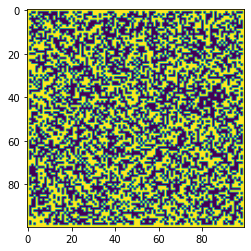

In [218]:
map=RandomMap(width,height,randomFillPercent)
ShowMap(map)

## Soft the map
Is a simple approach this is based on ask to my negihboards if are walls or are a passage, and the mayority determine if i am a Wall or a passage

In [219]:
def IsInMapRange(x, y, Map):
    w=np.size(Map,0)
    h=np.size(Map,1)
    if x>=0 and y>=0 and x<w and y<h:
        return True
    else:
        return False
def GetSurroundingWallCount(x,y,Map):
    wallCount=0
    w=np.size(Map,0)
    h=np.size(Map,1)
    Vx=[x-1,x,x+1]
    Vy=[y-1,y,y+1]
    for Nx in Vx:
        for Ny in Vy:
            if IsInMapRange(Nx,Ny,Map):
                if(Nx!=x or Ny!=y):
                    wallCount=wallCount+Map[Nx,Ny]
            else:
                wallCount=wallCount+1
    return wallCount
def SoftMap(Map,Times):
    w=np.size(Map,0)
    h=np.size(Map,1)
    for i in range(0,Times):
        for x in range(0,w):
            for y in range(0,h):
                Ne=GetSurroundingWallCount(x,y,Map)
                if Ne>4:
                    Map[x,y]=1
                elif Ne<4:
                    Map[x,y]=0
    return Map

Implementation

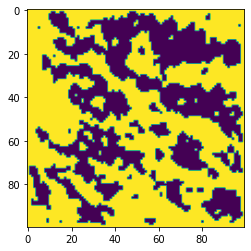

In [220]:
map=SoftMap(map,1)
ShowMap(map)

# Process the map
## Saving the positions
It's necesary to define a variable that can save the 2-D position

In [221]:
Coord= namedtuple('Coord' , 'tileX tileY')
TestOfCordinates = Coord(1, 1)
print(TestOfCordinates)

Coord(tileX=1, tileY=1)


## How can be separated the rooms
I start to grow in an initial position, if the map position is the same as the titletype, that can be a 0 or 1. Check that there is a mapFlags

In [222]:
def GetRegionTiles(startX,startY,Map):
    tiles=[]
    w=np.size(Map,0)
    h=np.size(Map,1)
    mapFlags=np.zeros([w,h])
    tileType=Map[startX,startY]
    queue=[]
    queue.append(Coord(startX,startY))
    mapFlags[startX,startY]=1
    while len(queue)>0:
        title=queue.pop(0)
        tiles.append(title)
        Vx=[title.tileX-1,title.tileX,title.tileX+1]
        Vy=[title.tileY-1,title.tileY,title.tileY+1]
        for x in Vx:
            for y in Vy:
                if IsInMapRange(x,y,Map)and (y==title.tileY or x==title.tileX):
                    if mapFlags[x,y]==0 and Map[x,y]==tileType:
                        mapFlags[x,y]=1
                        queue.append(Coord(x,y))
                    
    return tiles

Now i need to make a group to join every grup of titles, that are the same of the type, that it can be selected in title Type,
and if this don't be more that the Threashold values, they will drop out

In [223]:
def GetRegions(tileType,Map):
    regions=[]
    w=np.size(Map,0)
    h=np.size(Map,1)
    mapFlags=np.zeros([w,h])
    for x in range(0,w):
        for y in range(0,h):
            if mapFlags[x,y]==0 and Map[x,y]==tileType:
                NewRegion=GetRegionTiles(x,y,Map)
                regions.append(NewRegion)
                for v in NewRegion:
                    mapFlags[v.tileX,v.tileY]=1
    return regions


Testing the region process, it's useful to plot as a heatmap, based on the number that has the map in every value, but remember the values are pased by reference, so copy, will do a new variable to don't modify the original map

In [ ]:
def PlotRegions(Map,Regions):
    NewMap=Map.copy()
    #print(len(Regions))
    AdvancePerColor=0.5/len(Regions)
    randomColor=AdvancePerColor+0.2
    Primero=True

    for v in Regions:
        if Primero:
            Primero=False
        else:
            randomColor=AdvancePerColor+randomColor
        #print(randomColor)
        for i in v:
            NewMap[i.tileX,i.tileY]=randomColor
    sns.heatmap(NewMap)


Number of regions founded: 40


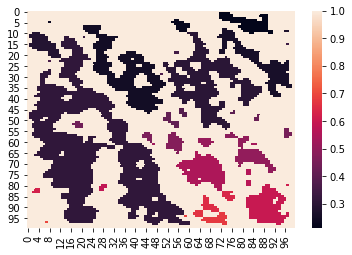

In [224]:
##For debuggin Only
# TestMap=RandomMap(30,30,0.5)
# TestMap=SoftMap(TestMap,2)
Regions=GetRegions(0,map)
print("Number of regions founded: "+str(len(Regions)))
PlotRegions(map,Regions)



The next class allow to save every room created and have a control over every one, 
having the number of ceils that are in, and taking in mind that is possible to know their value

In [225]:
class Room:
    titles=[]
    edgeTiles=[]
    connectedRooms=[]
    roomSize=0
    isAccessibleFromMainRoom=False
    isMainRoom=False
    def __init__(self, *args):
        if len(args)==0:
            self.titles=[]
            self.roomSize=0
            self.connectedRooms=[]
            self.edgeTiles=[]
        else:

            self.titles=args[0]
            self.roomSize=len(self.titles)
            self.connectedRooms=[]
            self.edgeTiles=[]
            Map=args[1]
        
            for v in self.titles:
                Vx=[v.tileX-1,v.tileX,v.tileX+1]
                Vy=[v.tileY-1,v.tileY,v.tileY+1]
                for x in Vx:
                    for y in Vy:
                        if x==v.tileX or y==v.tileY:
                            if Map[x,y]==1:
                                self.edgeTiles.append(v)
    def __str__(self):
        Texto='Titles: '+str(len(self.titles))+'\n'+"Edge: "+str(len(self.edgeTiles))+'\n'+"Size: "+str(self.roomSize)
        return Texto
    def SetAccessibleFromMainRoom(self):
        if not self.isAccessibleFromMainRoom:
            self.isAccessibleFromMainRoom=True
            for v in self.connectedRooms:
                v.SetAccessibleFromMainRoom()
    def IsConnected(self,otherRoom):
        if otherRoom in self.connectedRooms:
            return True
        else:
            return False
def CompareRooms(roomA,roomB):
    return roomA.roomSize==roomB.roomSize

                
def ConnectRooms(roomA,roomB):
    if(roomA.isAccessibleFromMainRoom):
        roomB.SetAccessibleFromMainRoom()
    elif(roomB.isAccessibleFromMainRoom):
        roomA.SetAccessibleFromMainRoom()
    roomA.connectedRooms.append(roomB)
    roomB.connectedRooms.append(roomA)


Test of emply constructor

In [226]:
Room()

### Sgn function
It's a function that return the value of the sign of the number
if value> 0 then it's equal to 1
else if value <0 that equal to -1
else equal at 0

In [227]:
def SgnFunction(value):
    ToRet=0
    if value>0:
        ToRet=1
    elif value<0:
        ToRet=-1
    return ToRet
    

Tests of the sgnFunction

In [189]:
print(SgnFunction(-1))
print(SgnFunction(0))
print(SgnFunction(2))

-1
0
1


To connect the rooms, it's useful to plan a type of line that will be on moving creating the discrete points that conform the line

In [190]:
def GetLine(_from,_to):
    line=[]
    x=_from.tileX
    y=_from.tileX

    dx=_to.tileX-x
    dy=_to.tileY-y

    Inverted=False;
    step=SgnFunction(dx)
    gradientStep=SgnFunction(dy)

    longest=np.abs(dx)
    shortest=np.abs(dy)

    if longest<shortest:
        Inverted=True
        longest=np.abs(dy)
        shortest=np.abs(dx)
        step=SgnFunction(dy)
        gradientStep=SgnFunction(dx)
    
    gradientAccumulation=longest/2
    for v in range(0,longest):
        line.append(Coord(x,y))
        if Inverted:
            y=y+step
        else:
            x=x+step
        gradientAccumulation=gradientAccumulation+shortest
        if(gradientAccumulation>=longest):
            if(Inverted):
                x=x+gradientStep
            else:
                y=y+gradientStep
            gradientAccumulation=gradientAccumulation-longest
    return line


Debugging of the line creation:
* Get the max posicion in every axis
* Add one to every one because the zero is another element in the axis
* Create a matrix with zeros
* Set the values of every point in the matrix, as 1, per point
* Plot with ShowMap

In [191]:
def PlotALine(CoordList):
    MaxX=CoordList[0].tileX
    MaxY=CoordList[0].tileY
    for v in CoordList:
        if v.tileX>MaxX:
            MaxX=v.tileX
        if v.tileY>MaxY:
            MaxY=v.tileY
    print(str(MaxX)+":"+str(MaxY))
    minimap=np.zeros([MaxX+1,MaxY+1])
    #print(minimap)
    for v in CoordList:
        minimap[v.tileX,v.tileY]=1
    ShowMap(minimap)

20:39


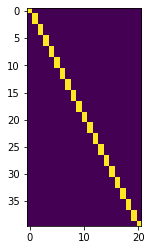

In [192]:
C1=Coord(0,0)
C2=Coord(20,40)
Line=GetLine(C1,C2)
PlotALine(Line)


In [193]:
def ConnectClosestRooms(Rooms,Map,forceAccessibilityFromMainRoom=False):
    print("Entering to connect the rooms")
    roomListA=[]
    roomListB=[]
    if forceAccessibilityFromMainRoom :
        for v in Rooms:
            if v.isAccessibleFromMainRoom:
                roomListB.append(v)
            else:
                roomListA.append(v)
        print("A method")
    else:
        roomListB=Rooms.copy()
        roomListA=Rooms.copy()
        print("B method")
    bestDistance=0
    bestTileA=Coord(0,0)
    bestTileB=Coord(0,0)
    bestRoomA=Room()
    bestRoomB=Room()
    print("Longitud A: "+str(len(roomListB)))
    print("Longitud B: "+str(len(roomListA)))
    possibleConnectionFound=False
    
    for roomA in roomListA:
        if not forceAccessibilityFromMainRoom:
            possibleConnectionFound=False
            if(len(roomA.connectedRooms)>0):
                continue
        for  roomB in  roomListB:
            if(CompareRooms(roomA,roomB) or roomA.IsConnected(roomB)):
                continue
            print("Edge Titles A: "+str(len(roomA.edgeTiles)))
            print("Edge Titles B: "+str(len(roomB.edgeTiles)))
            for tileIndexA in range(0,len(roomA.edgeTiles)):
                for tileIndexB in range(0,len(roomB.edgeTiles)):
                    tileA=roomA.edgeTiles[tileIndexA]
                    tileB=roomB.edgeTiles[tileIndexB]
                    dif1=tileA.tileX-tileB.tileX
                    dif2=tileA.tileY-tileB.tileY
                    distanceBetweenRooms = dif1*dif1+dif2*dif2
                    if distanceBetweenRooms < bestDistance or not possibleConnectionFound:
                        bestDistance = distanceBetweenRooms
                        possibleConnectionFound = True
                        bestTileA = tileA
                        bestTileB = tileB
                        bestRoomA = roomA
                        bestRoomB = roomB
        if possibleConnectionFound and not forceAccessibilityFromMainRoom:
            Map=CreatePassage(bestRoomA, bestRoomB, bestTileA, bestTileB,Map)
    
    if (possibleConnectionFound and forceAccessibilityFromMainRoom):
        Map=CreatePassage(bestRoomA, bestRoomB, bestTileA, bestTileB,Map)
        Map=ConnectClosestRooms(Rooms,Map, True);

    if (not forceAccessibilityFromMainRoom) :
        Map=ConnectClosestRooms(Rooms,Map,True)
    return Map


In [194]:
def CreatePassage(roomA, roomB, tileA, tileB,Map):
    print("Creating passage")
    ConnectRooms(roomA,roomB)
    Line=GetLine(tileA,tileB)
    for v in Line:
        Map=DrawCircule(v,PassageSize,Map)
    return Map

How to create a vector that represent the radius variancy

In [195]:
r=3
np.linspace(-r,r,num=r*2+1)

array([-3., -2., -1.,  0.,  1.,  2.,  3.])

In [206]:
def DrawCircule(c,r,Map): 
    Vx=np.linspace(-r,r,num=r*2+1)
    Vy=np.linspace(-r,r,num=r*2+1)
    print(type(Map))
    _r=r*r
    for x in Vx:
        for y in Vy:
            if x*x+y*y<=_r: #Circule relationship
                Dx=int(c.tileX+x)
                Dy=int(c.tileY+y)
                if IsInMapRange(Dx,Dy,Map):
                    Map[Dx,Dy]=0
    return Map

In [209]:
def ProcessMap(Map):
    NumberOfRooms=0
    survivingRooms=[]
    wallRegions=GetRegions(1,Map)
    for v in wallRegions:
        if int(len(v))<wallThresholdSize:
            for i in v:
                map[i.tileX,i.tileY]=0
                
    roomRegions = GetRegions(0,Map)
    for v in roomRegions:
        if int(len(v))<roomThresholdSize:
            for i in v:
                map[i.tileX,i.tileY]=1
        else:
            survivingRooms.append(Room(v, Map));
    ##This are the individual rooms as you can see in the image
    random.shuffle(survivingRooms)
    #Select one for all
    survivingRooms[0].isMainRoom=True
    survivingRooms[0].isAccessibleFromMainRoom=True
    print("Number of Rooms: "+str(len(survivingRooms)))
    # for v in survivingRooms:
    #     print(str(v))
    Map=ConnectClosestRooms(survivingRooms,Map,False)
    return Map


In [210]:
map=ProcessMap(map)

Number of Rooms: 1
Entering to connect the rooms
B method
Longitud A: 1
Longitud B: 1
Entering to connect the rooms
A method
Longitud A: 1
Longitud B: 0


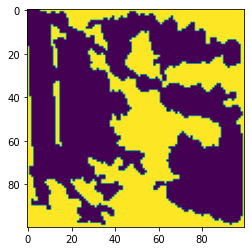

In [211]:
ShowMap(map)

## Add the border to the map
Only a mapping process conserving the walls in the map borders

In [212]:
def CreateABorderedMap(Map,borderSize):
    w=np.size(Map,0)
    h=np.size(Map,1)
    borderedMap=np.zeros([w+2*borderSize,h+2*borderSize])
    wb=np.size(borderedMap,0)
    hb=np.size(borderedMap,1)
    for x in range(0,wb):
        for y in range(0,hb):
            if x>=borderSize and y>=borderSize and x<w+borderSize  and y<h+borderSize:
                borderedMap[x,y]=Map[x-borderSize,y-borderSize]
            else:
                borderedMap[x,y]=1
    return borderedMap

Implementation

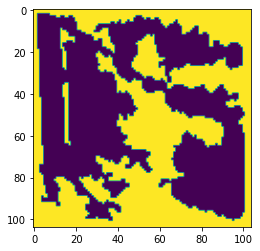

In [213]:
BorderMap=CreateABorderedMap(map,borderSize)
ShowMap(BorderMap)